In [4]:
!pip install optuna
!pip install nevergrad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.4/584.4 kB 68.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Preparing metadata (setup.py) ... done
  Created wheel for directsearch: filename=directsearch-1.0-py3-none-any.whl size=16299 sha256=e5220d36cdfcd12f28c6bc623f8148a475bbb13dfb691e29452dcd363c3d2308
  Stored in directory: /home/runai-home/.cache/pip/wheels/93/de/c0/ff1d2db2e4c2fcc4bb1f72ae2672860872d3bc42ea00bd1f4e
Successfully built directsearch

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [5]:
import sys
sys.path.append('../src')

[I 2025-09-16 15:59:33,482] A new study created in memory with name: no-name-48422b53-3070-4380-bd8d-afb58a358f89
[I 2025-09-16 15:59:33,487] A new study created in memory with name: no-name-c4bf315a-f784-4686-8c22-a502166b8fa8
[I 2025-09-16 15:59:33,491] A new study created in memory with name: no-name-a7c9cbbb-3414-412b-91db-be7bf5d1a728
[I 2025-09-16 15:59:33,495] A new study created in memory with name: no-name-e58561bb-4776-43e1-b148-325c72665503
[I 2025-09-16 15:59:33,499] A new study created in memory with name: no-name-47866145-5928-45d0-bf0b-de450592e34d


[baseline] arch=[512, 512], days=60, NE=0.559718
[info] Grid size=42; depths=[1..6], width_levels=7, first=[128], last=[2048, 2048, 2048, 2048, 2048, 2048]


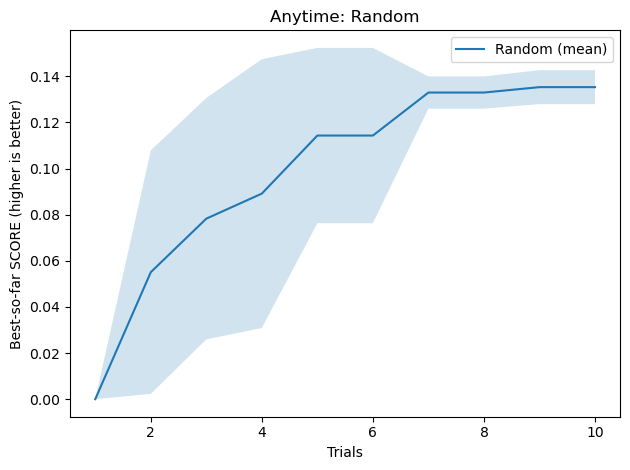

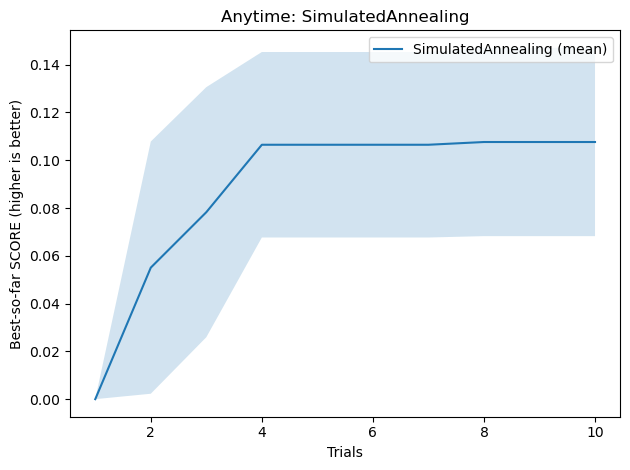

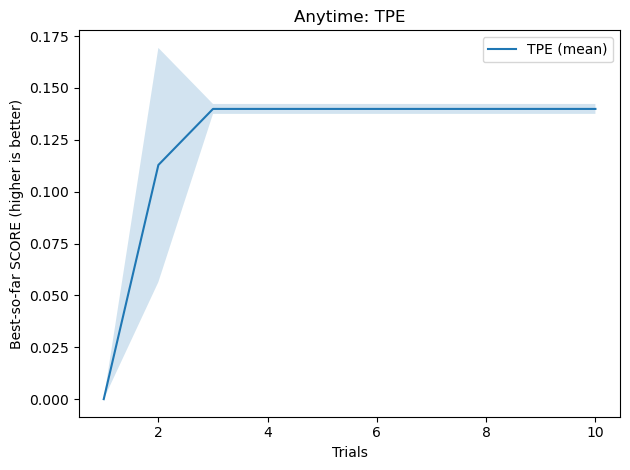

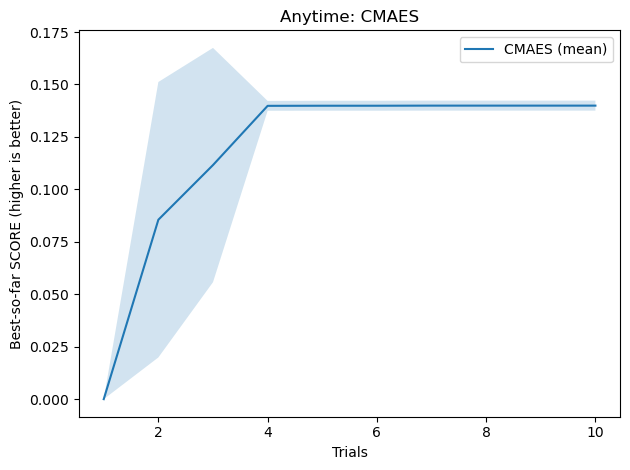

Saved CSVs to: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_results_arch_var_depth
Methods: ['Random', 'SimulatedAnnealing', 'TPE', 'CMAES']
Depth range: [1..6], width range: [128..2048] (log), N_WIDTHS=7
[baseline] arch=[512, 512], days=60, NE=0.559718
[seed] requested initial arch: [256, 256, 256] -> snapped to grid: [203, 203, 203]


In [22]:
# === ARCH-ONLY HPO (MAXIMIZATION) with variable depths + initial seed arch ===
from __future__ import annotations
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple
import time, math, random, json, csv
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from model_performance_api import ModelPerformanceAPI

# ---------------------------------------------------------------------
# GLOBAL SETTINGS (unchanged semantics)
# ---------------------------------------------------------------------
EVAL_TRAINING_DAYS = 60   # evaluate each arch for 60 days
N_TRIALS = 10             # 10 shots per method per seed (the initial seed counts as 1 if provided)
SEEDS = [0, 1, 2, 3, 4]

# Depth range (allow optimizer to explore different lengths)
MIN_DEPTH = 1
MAX_DEPTH = 6

# Width range (log-scale) used to construct the discrete grid
WIDTH_MIN = 128
WIDTH_MAX = 2048
N_WIDTHS  = 7  # number of log-scale width levels

# Optional: set your initial architecture (any length). Set to None to disable seeding.
INITIAL_ARCH: Optional[List[int]] = [256, 256, 256]  # example: length-3 start; change or set to None

# Baseline arch for scoring (your previous choice)
BASELINE_ARCH = [512, 512]

# Results directory
OUT_DIR = Path("benchmark_results_arch_var_depth")

# ---------------------------------------------------------------------
# Build model EXACTLY as you specified for the baseline (noise-free)
# ---------------------------------------------------------------------
_model_tmp = ModelPerformanceAPI()                                   # get defaults
_model_cfg = _model_tmp.get_default_model_config_dict()
_model_cfg["GLOBAL_NOISE_SCALE"] = 0.0                               # turn off noise
model_object = ModelPerformanceAPI(_model_cfg)                       # final simulator

def compute_baseline_ne(model: ModelPerformanceAPI, arch: List[int], days: int) -> float:
    ne, qps, curve = model.train_model(training_days=days, arch=arch, ignore_budget=True)
    return float(ne)

BASELINE_NE = compute_baseline_ne(model_object, BASELINE_ARCH, EVAL_TRAINING_DAYS)
print(f"[baseline] arch={BASELINE_ARCH}, days={EVAL_TRAINING_DAYS}, NE={BASELINE_NE:.6f}")

def get_score(ne: float, baseline_ne: float = BASELINE_NE) -> float:
    # Higher is better; 0 if not beating baseline.
    if baseline_ne <= 0:
        return 1.0 if ne < baseline_ne else 0.0
    return max((baseline_ne - ne) / baseline_ne, 0.0)

# ---------------------------------------------------------------------
# Variable-depth arch grid (log-scale widths) + adjacency (+ snap-to-grid)
# ---------------------------------------------------------------------
def _logspace_ints(lo: int, hi: int, n: int) -> List[int]:
    assert lo >= 1 and hi >= 1, "Layer widths must be >= 1"
    xs = np.exp(np.linspace(np.log(lo), np.log(hi), n))
    arr = np.rint(xs).astype(int).tolist()
    arr[0], arr[-1] = lo, hi
    for i in range(1, len(arr)):
        arr[i] = max(arr[i], arr[i-1])
    return arr

def build_union_arch_grid(min_depth: int, max_depth: int,
                          wmin: int, wmax: int, nwidths: int
                          ) -> Tuple[List[List[int]], Dict[tuple, List[tuple]], Dict[tuple, Tuple[int,int]]]:
    """
    Create a union grid of arches across depths.
    Each arch is 'homogeneous' (all layers same width) chosen from log-scale width set.
    Returns:
      arches: list of architectures (lists of ints)
      adjacency: map arch_tuple -> list of neighbor arch_tuples
      meta: map arch_tuple -> (depth_index, width_index) for internal bookkeeping
    """
    width_levels = _logspace_ints(wmin, wmax, nwidths)
    arches: List[List[int]] = []
    meta: Dict[tuple, Tuple[int,int]] = {}

    # Build arches ordered by (depth, width_idx)
    for d in range(min_depth, max_depth+1):
        for k, w in enumerate(width_levels):
            a = [w] * d
            arches.append(a)
            meta[tuple(a)] = (d, k)

    # Build adjacency: within-depth (k±1) and cross-depth (d±1, same k clamped)
    adjacency: Dict[tuple, List[tuple]] = {}
    for a_t, (d, k) in meta.items():
        nbrs = []
        # same depth neighbors
        if k - 1 >= 0:
            nbrs.append(tuple([width_levels[k-1]] * d))
        if k + 1 < len(width_levels):
            nbrs.append(tuple([width_levels[k+1]] * d))
        # depth neighbors
        if d - 1 >= min_depth:
            nbrs.append(tuple([width_levels[k]] * (d-1)))
        if d + 1 <= max_depth:
            nbrs.append(tuple([width_levels[k]] * (d+1)))
        # de-dup
        seen = set()
        clean = []
        for nb in nbrs:
            if nb != a_t and nb not in seen:
                clean.append(nb)
                seen.add(nb)
        adjacency[a_t] = clean

    # materialize arches back to lists in case of dedup (consistent order)
    arches = [list(a) for a in dict.fromkeys([tuple(a) for a in arches]).keys()]
    return arches, adjacency, meta

ARCH_GRID, ARCH_ADJ, ARCH_META = build_union_arch_grid(MIN_DEPTH, MAX_DEPTH, WIDTH_MIN, WIDTH_MAX, N_WIDTHS)
print(f"[info] Grid size={len(ARCH_GRID)}; "
      f"depths=[{MIN_DEPTH}..{MAX_DEPTH}], width_levels={N_WIDTHS}, "
      f"first={ARCH_GRID[0]}, last={ARCH_GRID[-1]}")

def snap_to_grid(arch: List[int], grid: List[List[int]]) -> List[int]:
    """
    Snap an arbitrary arch to the nearest grid arch:
    - depth: clip to [MIN_DEPTH, MAX_DEPTH]
    - width: use geometric mean of widths in 'arch' to choose nearest width level
    """
    if not arch:
        return grid[0]
    d = len(arch)
    d = max(MIN_DEPTH, min(MAX_DEPTH, d))
    # geometric mean width
    g = math.exp(sum(math.log(max(1, w)) for w in arch) / len(arch))
    # pull allowed width levels from grid meta (they're the same for every depth)
    width_levels = sorted({a[0] for a in grid if len(a) >= 1})
    # choose nearest in log space
    idx = min(range(len(width_levels)), key=lambda i: abs(math.log(width_levels[i]) - math.log(g)))
    snapped = [width_levels[idx]] * d
    return snapped

# ---------------------------------------------------------------------
# Search space & suggestors (arch-only, supports variable depths)
# ---------------------------------------------------------------------
@dataclass
class ArchChoice:
    name: str
    arches: List[List[int]]
    adjacency: Optional[Dict[tuple, List[tuple]]] = None  # tuple-keys

SearchVar = ArchChoice

@dataclass
class SearchSpace:
    vars: List[SearchVar]
    def sample(self, rng: np.random.RandomState) -> Dict[str, Any]:
        v = self.vars[0]
        idx = int(rng.randint(0, len(v.arches)))
        return {v.name: v.arches[idx]}

space = SearchSpace(vars=[ArchChoice("arch", arches=ARCH_GRID, adjacency=ARCH_ADJ)])

class Suggestor:
    name: str = "Suggestor"
    def reset(self, seed: int): ...
    def ask(self, space: SearchSpace, rng: np.random.RandomState) -> Dict[str, Any]: ...
    def tell(self, config: Dict[str, Any], value: float): ...

class RandomSuggestor(Suggestor):
    name = "Random"
    def reset(self, seed: int): random.seed(seed)
    def ask(self, space: SearchSpace, rng: np.random.RandomState) -> Dict[str, Any]:
        return space.sample(rng)
    def tell(self, config: Dict[str, Any], value: float): pass

def _pick_one(rng: np.random.RandomState, seq: List[Any]) -> Any:
    return seq[int(rng.randint(0, len(seq)))]

def _neighbor(space: SearchSpace,
              cfg: Dict[str, Any],
              rng: np.random.RandomState,
              local_prob: float = 0.8) -> Dict[str, Any]:
    """
    Adjacent-aware neighbor for variable-depth ArchChoice:
      - local move (prob=local_prob): width index ±1 or depth ±1 (via adjacency)
      - global jump otherwise: random arch from the full grid
    """
    new_cfg = dict(cfg)
    v = space.vars[0]  # only "arch"
    current = tuple(new_cfg[v.name])
    candidates = []
    if v.adjacency is not None and current in v.adjacency and (rng.rand() < local_prob):
        # local moves
        candidates = [list(t) for t in v.adjacency[current]]
    else:
        # global jump
        candidates = [a for a in v.arches if tuple(a) != current]
    if candidates:
        new_cfg[v.name] = _pick_one(rng, candidates)
    return new_cfg

class SimulatedAnnealingSuggestor(Suggestor):
    name = "SimulatedAnnealing"
    def __init__(self, T0: float=0.5, alpha: float=0.996, warmup: int=3, local_prob: float=0.8):
        self.T0 = T0; self.alpha = alpha; self.warmup = warmup
        self.local_prob = local_prob
        self._x = None; self._fx = None; self._T = T0
        self._n_evals = 0
    def reset(self, seed: int):
        random.seed(seed)
        self._x = None; self._fx = None; self._T = self.T0
        self._n_evals = 0
    def ask(self, space: SearchSpace, rng: np.random.RandomState) -> Dict[str, Any]:
        if self._x is None or self._n_evals < self.warmup:
            cfg = space.sample(rng)
        else:
            cfg = _neighbor(space, self._x, rng, local_prob=self.local_prob)
        return cfg
    def tell(self, config: Dict[str, Any], value: float):
        # MAXIMIZATION over "score"
        self._n_evals += 1
        if self._fx is None:
            self._x, self._fx = config, float(value)
            return
        if self._n_evals <= self.warmup:
            if value > self._fx:
                self._x, self._fx = config, float(value)
            return
        delta = float(value) - float(self._fx)  # new - old
        accept = (delta >= 0) or (random.random() < math.exp(delta / max(self._T, 1e-12)))
        if accept:
            self._x, self._fx = config, float(value)
        self._T *= self.alpha

# Optional: TPE & CMA-ES (work on the discrete union grid)
class TPESuggestor(Suggestor):
    name = "TPE"
    def __init__(self, space: SearchSpace):
        try:
            import optuna  # noqa: F401
        except Exception as e:
            raise RuntimeError("Optuna not available: pip install -U optuna") from e
        self.space = space
        self._optuna = __import__("optuna")
        self._study = None
        self._last_trial = None
    def reset(self, seed: int):
        sampler = self._optuna.samplers.TPESampler(seed=seed)
        self._study = self._optuna.create_study(direction="maximize", sampler=sampler)
        self._last_trial = None
        # If you want TPE to *start* with the seed arch, we enqueue it below in Benchmark.run via tell()
    def ask(self, space: SearchSpace, rng: np.random.RandomState) -> Dict[str, Any]:
        trial = self._study.ask()
        v = self.space.vars[0]
        as_str = [json.dumps(a) for a in v.arches]
        choice = trial.suggest_categorical(v.name, as_str)
        cfg = {v.name: json.loads(choice)}
        self._last_trial = trial
        return cfg
    def tell(self, config: Dict[str, Any], value: float):
        if self._last_trial is not None:
            self._study.tell(self._last_trial, float(value))
            self._last_trial = None

class CMAESSuggestor(Suggestor):
    name = "CMAES"
    def __init__(self, space: SearchSpace):
        try:
            import nevergrad as ng  # noqa: F401
        except Exception as e:
            raise RuntimeError("Nevergrad not available: pip install nevergrad") from e
        self.space = space
        self._ng = __import__("nevergrad")
        v = self.space.vars[0]
        self._param = self._ng.p.Dict(**{v.name: self._ng.p.Choice([json.dumps(a) for a in v.arches])})
        self._opt = None
        self._cache = {}
        self._t = 0
    def reset(self, seed: int):
        self._opt = self._ng.optimizers.CMA(parametrization=self._param, budget=10**7)
        self._cache = {}; self._t = 0
    def ask(self, space: SearchSpace, rng: np.random.RandomState) -> Dict[str, Any]:
        rec = self._opt.ask()
        v = self.space.vars[0]
        cfg = rec.value
        if isinstance(cfg[v.name], str):
            cfg[v.name] = json.loads(cfg[v.name])
        self._cache[self._t] = rec
        return cfg
    def tell(self, config: Dict[str, Any], value: float):
        rec = self._cache.pop(self._t, None)
        if rec is not None:
            self._opt.tell(rec, -float(value))  # CMA minimizes → maximize score via negative
        self._t += 1

# ---------------------------------------------------------------------
# Benchmark & logging (MAXIMIZATION over SCORE), with optional initial seed arch
# ---------------------------------------------------------------------
@dataclass
class Trial:
    config: Dict[str, Any]
    value: float   # score
    elapsed: float
    seed: int

@dataclass
class RunLog:
    method: str
    trials: List[Trial]
    def best_curve(self) -> List[float]:
        best = -float("inf")
        out = []
        for t in self.trials:
            best = max(best, t.value)
            out.append(best)
        return out

class Benchmark:
    def __init__(self, evaluate_fn, space: SearchSpace):
        self.evaluate = evaluate_fn
        self.space = space

    def run(self, suggestor: Suggestor, n_trials: int=N_TRIALS, seed: int=0,
            initial_arch: Optional[List[int]] = INITIAL_ARCH) -> RunLog:
        rng = np.random.RandomState(seed)
        random.seed(seed)
        suggestor.reset(seed)
        trials: List[Trial] = []

        # If an initial seed is provided, snap it to the grid and evaluate first.
        used = 0
        if initial_arch is not None:
            cfg0 = {"arch": snap_to_grid(initial_arch, self.space.vars[0].arches)}
            t0 = time.time()
            val0 = float(self.evaluate(cfg0))
            dt0 = time.time() - t0
            suggestor.tell(cfg0, val0)  # seed internal state / tell TPE study
            trials.append(Trial(cfg0, val0, dt0, seed))
            used = 1

        for _ in range(n_trials - used):
            cfg = suggestor.ask(self.space, rng)
            t0 = time.time()
            val = float(self.evaluate(cfg))  # score
            dt = time.time() - t0
            suggestor.tell(cfg, val)
            trials.append(Trial(cfg, val, dt, seed))
        return RunLog(method=suggestor.name, trials=trials)

def save_runs(results: Dict[str, List[RunLog]], out_dir: Path):
    out_dir.mkdir(exist_ok=True, parents=True)
    for method, runs in results.items():
        for i, run in enumerate(runs):
            fp = out_dir / f"{method}_seed{i}.csv"
            with fp.open("w", newline="") as f:
                w = csv.writer(f)
                w.writerow(["step","best_so_far","value","elapsed","config_json"])
                best = -float("inf")
                for t, tr in enumerate(run.trials, start=1):
                    best = max(best, tr.value)   # cumulative MAX score
                    w.writerow([t, best, tr.value, tr.elapsed, json.dumps(tr.config)])

def save_arches_per_method(results: Dict[str, List[RunLog]], out_dir: Path):
    out_dir.mkdir(exist_ok=True, parents=True)
    for method, runs in results.items():
        fp = out_dir / f"{method}_arches.csv"
        with fp.open("w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["seed","step","arch_json","score"])
            for i, run in enumerate(runs):
                seed_id = run.trials[0].seed if run.trials else i
                for step, tr in enumerate(run.trials, start=1):
                    arch = tr.config.get("arch")
                    w.writerow([seed_id, step, json.dumps(arch), tr.value])

def plot_runs(results: Dict[str, List[RunLog]]):
    for method, runs in results.items():
        L = min(len(r.trials) for r in runs)
        curves = np.array([r.best_curve()[:L] for r in runs], dtype=float)
        mean, std = curves.mean(0), curves.std(0)
        x = np.arange(1, L+1)
        plt.figure()
        plt.plot(x, mean, label=f"{method} (mean)")
        plt.fill_between(x, mean-std, mean+std, alpha=0.2)
        plt.xlabel("Trials")
        plt.ylabel("Best-so-far SCORE (higher is better)")
        plt.title(f"Anytime: {method}")
        plt.legend(); plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------
# Objective: evaluate -> SCORE (higher is better)
# ---------------------------------------------------------------------
def evaluate_cfg(cfg: Dict[str, Any]) -> float:
    arch = cfg["arch"]
    ne, qps, curve = model_object.train_model(
        arch=arch,
        training_days=EVAL_TRAINING_DAYS,
        ignore_budget=True
    )
    return get_score(float(ne), baseline_ne=BASELINE_NE)

# ---------------------------------------------------------------------
# Run benchmark (all methods start with the same initial seed if provided)
# ---------------------------------------------------------------------
bench = Benchmark(evaluate_cfg, space)

suggestors: List[Suggestor] = [
    RandomSuggestor(),
    SimulatedAnnealingSuggestor(T0=0.5, alpha=0.996, warmup=3, local_prob=0.8),
]

# Optional methods if installed
try:
    suggestors.append(TPESuggestor(space))  # maximize
except Exception as e:
    print("TPE disabled:", e)
try:
    suggestors.append(CMAESSuggestor(space))  # uses -score internally
except Exception as e:
    print("CMA-ES disabled:", e)

results: Dict[str, List[RunLog]] = {}
for sug in suggestors:
    results[sug.name] = []
    for s in SEEDS:
        results[sug.name].append(bench.run(sug, n_trials=N_TRIALS, seed=s, initial_arch=INITIAL_ARCH))

save_runs(results, OUT_DIR)
save_arches_per_method(results, OUT_DIR)
plot_runs(results)

print("Saved CSVs to:", OUT_DIR.resolve())
print("Methods:", list(results.keys()))
print(f"Depth range: [{MIN_DEPTH}..{MAX_DEPTH}], width range: [{WIDTH_MIN}..{WIDTH_MAX}] (log), N_WIDTHS={N_WIDTHS}")
print(f"[baseline] arch={BASELINE_ARCH}, days={EVAL_TRAINING_DAYS}, NE={BASELINE_NE:.6f}")
if INITIAL_ARCH is not None:
    print(f"[seed] requested initial arch: {INITIAL_ARCH} -> snapped to grid: {snap_to_grid(INITIAL_ARCH, ARCH_GRID)}")


=== SUMMARY (higher is better) ===


,method,aligned_trials,seeds,final_mean,final_std,auc_mean_curve
0,TPE,10,10,0.314630,0.174759,2.874413
1,CMAES,10,10,0.311872,0.172035,2.819393
2,Random,10,10,0.310709,0.175536,2.745760
3,SimulatedAnnealing,10,10,0.305866,0.200822,2.729220


Saved: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_analytics_max/summary_max.csv

=== RANKS (by final best-so-far SCORE; higher is better) ===


,method,final_mean,rank_by_final
0,TPE,0.314630,1
1,CMAES,0.311872,2
2,Random,0.310709,3
3,SimulatedAnnealing,0.305866,4


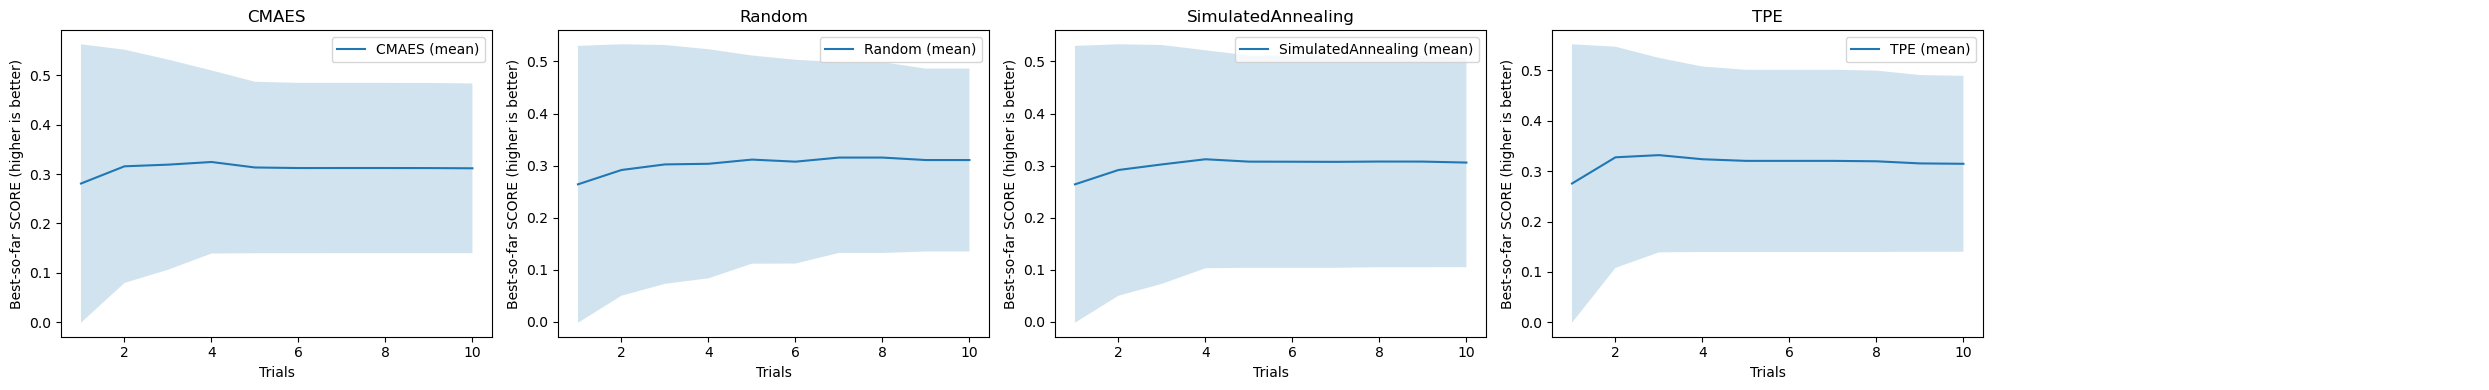


=== Best arch per seed (per method) ===


,method,seed,arch_json,score
0,CMAES,0,"[2048, 2048, 2048]",0.141109
1,CMAES,1,"[2048, 2048, 2048, 2048]",0.141109
2,CMAES,2,"[1290, 1290, 1290, 1290, 1290, 1290]",0.141109
3,CMAES,3,"[2048, 2048, 2048, 2048, 2048, 2048]",0.141109
4,CMAES,4,"[1290, 1290, 1290, 1290]",0.135126
5,Random,0,"[1290, 1290, 1290]",0.129395
6,Random,1,"[1290, 1290]",0.123665
7,Random,2,"[1290, 1290, 1290, 1290, 1290, 1290]",0.141109
8,Random,3,"[2048, 2048, 2048, 2048, 2048, 2048]",0.141109
9,Random,4,"[1290, 1290, 1290, 1290, 1290, 1290]",0.141109


Saved: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_analytics_max/best_arch_per_seed.csv

=== Depth histogram (counts of tried depths) ===


,method,depth,count
0,CMAES,1,7
1,CMAES,2,5
2,CMAES,3,13
3,CMAES,4,8
4,CMAES,5,9
5,CMAES,6,8
6,Random,1,9
7,Random,2,13
8,Random,3,11
9,Random,4,6


Saved: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_analytics_max/depth_histogram.csv

=== Top-5 arches by best score (per method) ===


,method,arch_json,best_score
0,Random,"[2048, 2048, 2048, 2048, 2048, 2048]",0.141109
1,Random,"[2048, 2048, 2048, 2048, 2048]",0.141109
2,Random,"[1290, 1290, 1290, 1290, 1290, 1290]",0.141109
3,Random,"[1290, 1290, 1290]",0.129395
4,Random,"[813, 813, 813, 813, 813, 813]",0.125850
5,CMAES,"[2048, 2048, 2048]",0.141109
6,CMAES,"[2048, 2048, 2048, 2048]",0.141109
7,CMAES,"[2048, 2048, 2048, 2048, 2048, 2048]",0.141109
8,CMAES,"[1290, 1290, 1290, 1290, 1290, 1290]",0.141109
9,CMAES,"[1290, 1290, 1290, 1290, 1290]",0.140857


Saved: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_analytics_max/topk_arches.csv

Done. Outputs in: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_analytics_max


In [23]:
# === JUPYTER CELL: Plot & summarize MAXIMIZATION results (SCORE: higher is better) ===
# Assumes CSVs have columns: step,best_so_far,value,elapsed,config_json
# and best_so_far is already a cumulative MAX (higher is better).
# Also consumes per-method "*_arches.csv" saved by the harness.

from __future__ import annotations
import csv, json, ast
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------------
RESULT_DIRS = [
    "benchmark_results_arch_var_depth",  # new harness default
    "benchmark_results_class_api",       # older runs (if any)
    "benchmark_results",                 # older runs (if any)
]
OUTPUT_DIR = Path("benchmark_analytics_max")
WRITE_SUMMARY_CSV   = True
WRITE_SUMMARY_LATEX = False  # set True if you want LaTeX

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------------------
# LOADING (curves)
# ---------------------------------------------------------------------
def load_all_curves(dirs: List[str]) -> Dict[str, List[np.ndarray]]:
    """
    Loads all result CSVs and groups them by method.
    Returns {method: [best_so_far_curve_seed0, best_so_far_curve_seed1, ...]}.
    Ignores '*_arches.csv'.
    """
    method_to_curves: Dict[str, List[np.ndarray]] = {}
    for root in dirs:
        p = Path(root)
        if not p.exists():
            continue
        for fp in p.glob("*.csv"):
            if fp.name.endswith("_arches.csv"):
                continue  # handled in a separate loader
            name = fp.stem  # e.g., "SimulatedAnnealing_seed3"
            method = name.split("_seed")[0] if "_seed" in name else name
            bests = []
            with fp.open("r", newline="") as f:
                r = csv.DictReader(f)
                for row in r:
                    if row.get("best_so_far") is not None:
                        try:
                            bests.append(float(row["best_so_far"]))
                        except:
                            pass
            if bests:
                method_to_curves.setdefault(method, []).append(np.asarray(bests, dtype=float))
    return method_to_curves

method_to_curves = load_all_curves(RESULT_DIRS)
if not method_to_curves:
    raise FileNotFoundError(f"No result CSVs found under {RESULT_DIRS}. Did you run the benchmark?")

methods = sorted(method_to_curves.keys())

# ---------------------------------------------------------------------
# METRICS & STATS (MAXIMIZATION)
# ---------------------------------------------------------------------
def align_to_min_length(curves: List[np.ndarray]) -> Tuple[np.ndarray, int]:
    """Stack seed curves to minimal common length L → returns (A, L) where A is [n_seeds, L]."""
    L = min(len(c) for c in curves)
    A = np.vstack([c[:L] for c in curves])
    return A, L

def auc_trapz(y: np.ndarray) -> float:
    """
    Trapezoidal area under the (best-so-far) curve.
    For MAXIMIZATION with best-so-far **scores**, LARGER AUC is better.
    """
    x = np.arange(len(y), dtype=float)
    return float(np.trapz(y, x))

def compute_summary_max(method_to_curves: Dict[str, List[np.ndarray]]) -> pd.DataFrame:
    rows = []
    for m, curves in method_to_curves.items():
        A, L = align_to_min_length(curves)
        mean_curve = A.mean(axis=0)
        final_per_seed = A[:, -1]  # final best-so-far score for each seed
        rows.append({
            "method": m,
            "aligned_trials": L,
            "seeds": A.shape[0],
            "final_mean": float(final_per_seed.mean()),   # HIGHER is better
            "final_std": float(final_per_seed.std()),
            "auc_mean_curve": auc_trapz(mean_curve),      # HIGHER is better
        })
    # For MAXIMIZATION: sort DESC (higher is better)
    df = pd.DataFrame(rows).sort_values(
        ["final_mean", "auc_mean_curve"], ascending=[False, False], ignore_index=True
    )
    return df

summary_df = compute_summary_max(method_to_curves)

print("=== SUMMARY (higher is better) ===")
display(summary_df)

if WRITE_SUMMARY_CSV:
    out_csv = OUTPUT_DIR / "summary_max.csv"
    summary_df.to_csv(out_csv, index=False)
    print("Saved:", out_csv.resolve())

if WRITE_SUMMARY_LATEX:
    out_tex = OUTPUT_DIR / "summary_max.tex"
    with out_tex.open("w") as f:
        f.write(summary_df.to_latex(index=False, float_format="%.4f"))
    print("Saved:", out_tex.resolve())

# Rank table by final mean (descending)
rank_df = summary_df[["method","final_mean"]].copy()
rank_df["rank_by_final"] = rank_df["final_mean"].rank(ascending=False, method="min").astype(int)
rank_df = rank_df.sort_values(["rank_by_final","final_mean"], ascending=[True, False])
print("\n=== RANKS (by final best-so-far SCORE; higher is better) ===")
display(rank_df)

# ---------------------------------------------------------------------
# PLOTTING: small multiples (5 per row), higher is better
# ---------------------------------------------------------------------
def plot_row_of_five(methods: List[str], method_to_curves: Dict[str, List[np.ndarray]]):
    """Small multiples: up to 5 methods per row (higher is better)."""
    cols = 5
    n = len(methods)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), squeeze=False)
    for idx, m in enumerate(methods):
        r, c = divmod(idx, cols)
        ax = axes[r][c]
        A, L = align_to_min_length(method_to_curves[m])
        mean, std = A.mean(0), A.std(0)
        x = np.arange(1, L+1)
        ax.plot(x, mean, label=f"{m} (mean)")
        ax.fill_between(x, mean-std, mean+std, alpha=0.2)
        ax.set_title(m)
        ax.set_xlabel("Trials")
        ax.set_ylabel("Best-so-far SCORE (higher is better)")
        ax.legend()
    # Hide unused subplots
    for j in range(n, rows*cols):
        r, c = divmod(j, cols)
        axes[r][c].axis("off")
    plt.tight_layout()
    plt.show()

plot_row_of_five(methods, method_to_curves)

# ---------------------------------------------------------------------
# LOADING (arches tried) + summaries
# ---------------------------------------------------------------------
def load_arch_logs(dirs: List[str]) -> Dict[str, pd.DataFrame]:
    """
    Load '*_arches.csv' per method and concatenate across dirs.
    Returns {method: df} where df has columns [seed, step, arch_json, score].
    """
    out: Dict[str, List[pd.DataFrame]] = {}
    for root in dirs:
        p = Path(root)
        if not p.exists():
            continue
        for fp in p.glob("*_arches.csv"):
            method = fp.stem.replace("_arches", "")
            df = pd.read_csv(fp)
            # normalize column names just in case
            df = df.rename(columns={col: col.strip().lower() for col in df.columns})
            # expected: seed, step, arch_json, score
            if not {"seed","step","arch_json","score"}.issubset(df.columns):
                continue
            out.setdefault(method, []).append(df[["seed","step","arch_json","score"]].copy())
    # concat per method
    method_to_df: Dict[str, pd.DataFrame] = {}
    for m, parts in out.items():
        method_to_df[m] = pd.concat(parts, ignore_index=True)
    return method_to_df

def parse_arch(s: str) -> List[int]:
    # arch_json is written via json.dumps(list); robust loader:
    try:
        return json.loads(s)
    except Exception:
        try:
            return ast.literal_eval(s)
        except Exception:
            return []

method_to_archlogs = load_arch_logs(RESULT_DIRS)

if not method_to_archlogs:
    print("\n[warn] No '*_arches.csv' files found; did you call save_arches_per_method(...) in the harness?")
else:
    # ---- Final best arch per seed (per method) ----
    rows_best = []
    for m, df in method_to_archlogs.items():
        # best per seed = row with max score per seed
        idx = df.groupby("seed")["score"].idxmax()
        best_df = df.loc[idx, ["seed", "arch_json", "score"]].copy()
        best_df.insert(0, "method", m)
        rows_best.append(best_df)
    best_arch_per_seed = pd.concat(rows_best, ignore_index=True) if rows_best else pd.DataFrame()
    print("\n=== Best arch per seed (per method) ===")
    if not best_arch_per_seed.empty:
        display(best_arch_per_seed.sort_values(["method","seed"]).reset_index(drop=True))
        best_arch_per_seed.to_csv(OUTPUT_DIR / "best_arch_per_seed.csv", index=False)
        print("Saved:", (OUTPUT_DIR / "best_arch_per_seed.csv").resolve())

    # ---- Depth histogram (how many layers tried) ----
    rows_depth = []
    for m, df in method_to_archlogs.items():
        depths = df["arch_json"].map(lambda s: len(parse_arch(s)))
        hist = depths.value_counts().sort_index()
        tmp = pd.DataFrame({"method": m, "depth": hist.index, "count": hist.values})
        rows_depth.append(tmp)
    depth_hist = pd.concat(rows_depth, ignore_index=True) if rows_depth else pd.DataFrame()
    print("\n=== Depth histogram (counts of tried depths) ===")
    if not depth_hist.empty:
        display(depth_hist.sort_values(["method","depth"]).reset_index(drop=True))
        depth_hist.to_csv(OUTPUT_DIR / "depth_histogram.csv", index=False)
        print("Saved:", (OUTPUT_DIR / "depth_histogram.csv").resolve())

    # ---- Top-K unique arches by BEST score (across all seeds/steps) ----
    TOP_K = 5
    rows_topk = []
    for m, df in method_to_archlogs.items():
        # best score for each unique arch
        grp = df.groupby("arch_json")["score"].max().sort_values(ascending=False)
        top = grp.head(TOP_K).reset_index().rename(columns={"score":"best_score"})
        top.insert(0, "method", m)
        rows_topk.append(top)
    topk_arches = pd.concat(rows_topk, ignore_index=True) if rows_topk else pd.DataFrame()
    print(f"\n=== Top-{TOP_K} arches by best score (per method) ===")
    if not topk_arches.empty:
        display(topk_arches)
        topk_arches.to_csv(OUTPUT_DIR / "topk_arches.csv", index=False)
        print("Saved:", (OUTPUT_DIR / "topk_arches.csv").resolve())

print("\nDone. Outputs in:", OUTPUT_DIR.resolve())
